# <p style="text-align: center;">**Bootcamp Big Data & Machine Learning V</p>**

**<p style="text-align: center;">NLP - Práctica Final</p>**</br>
**<p style="text-align: center;">Alberto Muñoz Freán</p>**

**1) Topic Modeling:**

En primer lugar, se hará un modelado de topics utilizando un dataset de reviews de Amazon. Para crear este dataset, utilizaremos cuatro categorías del [Amazon review data](http://jmcauley.ucsd.edu/data/amazon/):
<br>**Clothing, Shoes and Jewelry**<br> 
**Sports and Outdoors**<br> 
**Cell Phones and Accessories**<br>
**Tools and Home Improvement**

In [34]:
#Importamos todos los paquetes necesarios para hacer topic modeling:
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import string
from nltk.stem import WordNetLemmatizer

In [35]:
#Cargamos los archivos json que contienen las reviews en sendos dataframe:
reviews_tools = pd.read_json('Tools_and_Home_Improvement_5.json', orient='columns', lines=True)
reviews_phones = pd.read_json('Cell_Phones_and_Accessories_5.json', orient='columns', lines=True)
reviews_clothing = pd.read_json('Clothing_Shoes_and_Jewelry_5.json', orient='columns', lines=True)
reviews_sports = pd.read_json('Sports_and_Outdoors_5.json', orient='columns', lines=True)

In [11]:
#Topic modeling requiere tiempos largos de entrenamiento si se usan muchos datos, de modo que es mejor optimizar el modelo 
#con una muestra aleatoria más reducida de los datos, para después probar sobre el conjunto completo:

#Trabajaremos con 100 entradas, de modo que usaremos 25 registros aleatorios de cada topic para equilibrar el dataset:
tools25 = reviews_tools.sample(25)
phones25 = reviews_phones.sample(25)
clothing25 = reviews_clothing.sample(25)
sports25 = reviews_sports.sample(25)

#Unimos los cuatro subsets en un solo data frame:
df1 = tools25.combine_first(phones25)
df2 = df1.combine_first(clothing25)
df3 = df2.combine_first(sports25)

#Hacemos un shuffle de todos los resultados, de modo que estén mezclados y no por orden de entrada en el dataset conjunto:
df = df3.sample(frac=1)

#Confirmamos el resultado comprobando que el data frame final tiene 100 entradas:
df.shape

(100, 9)

In [12]:
#Confirmamos también que los registros están mezclados:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
274458,ABF4MT5O58BFH,B00FR6AYS0,Chelsea Fricke,"[0, 0]","Like some of the other reviews, this hat isn't...",4.0,Pretty good hat,1.390003e+09,"01 18, 2014"
270543,A3UCID8WQPOTY7,B008JH56AA,"Tracy L. Perman ""aZX14blurr""","[0, 0]","fit my caldwell CLA pipod just fine, and is th...",3.0,"works, but needs thumb screws instead of reces...",1.399507e+09,"05 8, 2014"
75381,A3Q5W5E7TDVLJF,B001NI4JWI,funnyc130,"[3, 3]",This stuff is very thin. It dries very very qu...,5.0,Super thin,1.378944e+09,"09 12, 2013"
146332,A2AZFMRH2QA03V,B00551OXU2,"LavenderGrove ""Mbb_Girl""","[0, 0]",I got this bra after a friend recommended it t...,5.0,Great Comfy Bra,1.354666e+09,"12 5, 2012"
51214,A2GUMWE50XCT1A,B00120WEME,jessalyn johnson,"[0, 0]",I ordered 7.5 twice and both pairs were huge! ...,3.0,I ordered my size and too big,1.393286e+09,"02 25, 2014"


In [16]:
#Nos quedamos con el campo "reviewText", que es el que vamos a estudiar, y eliminamos los registros nulos:
df = df[['reviewText']]
df.dropna(inplace=True)

C:\Users\amfre\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
#Guardamos el resultado en un csv para poder reutilizarlo en caso de tener que cerrar el notebook:
df.to_csv(r'Topic_Modeling.csv', index = False)

- Una vez preparados los datos, procederemos a generar todos los parámetros que necesita un modelo basado en LDA (Latent Dirichlet Allocation) para funcionar. Esto es, un corpus, un diccionario id-palabra y un número de topics. 

- Haremos distintos tipos de preprocesado, observando cómo afecta ésto a los resultados del LDA.

- Para evaluar topic modeling, es posible dividir el dataset en train y test. Después, se entrena y optimiza en train, y finalmente se observa sobre el dataset de test la Perplexity (precisión de un modelo a la hora de predecir resultados sobre una muestra no conocida). Sin embargo, quizá sea más útil inspeccionar los resultados del modelo manualmente, de manera que podamos inferir nuestras propias conclusiones sobre la adecuación de los topics. Esto es más que factible, teniendo en cuenta que conocemos los temas principales de las reviews que componen el dataset.

**A: Tokenización + Eliminación de stopwords y palabras cortas (< 3 caracteres)**

In [3]:
#Tokenizar convierte el texto en palabraas individuales que el modelo puede estudiar, review a review. 
#Las stopwords y palabras cortas son aquellas palabras sin significado en la oración que solo producirían ruido. Eliminarlas
#parece arrojar mejores resultados cuando se usa LDA.
#Para hacer estos dos cambios iniciales, usaremos la librería Gensim:

#Definimos una función que genere los tokens de acuerdo con las palabras que encuentra en el texto:
def text_preprocessing(text):
    result=[] 
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: #Definimos los criterios de exclusión:
            result.append(token)
    return result

processed_texts = [] #Creamos una lista vacía donde introducir los tokens
for text in df['reviewText']:
    processed_texts.append(text_preprocessing(text)) #Ejecutamos la función previa sobre nuestro dataset
    
#Comprobamos el resultado:
print(processed_texts)

In [19]:
#Generamos el diccionario id-palabra que requiere el LDA:
dictionary = Dictionary(processed_texts)
#Imprimimos el resultado:
list(dictionary.items())

[(0, 'baggy'),
 (1, 'couldn'),
 (2, 'funny'),
 (3, 'head'),
 (4, 'issue'),
 (5, 'kinda'),
 (6, 'like'),
 (7, 'pretty'),
 (8, 'reviews'),
 (9, 'size'),
 (10, 'smelled'),
 (11, 'think'),
 (12, 'wash'),
 (13, 'wear'),
 (14, 'adapter'),
 (15, 'allen'),
 (16, 'caldwell'),
 (17, 'carry'),
 (18, 'fine'),
 (19, 'hardware'),
 (20, 'hold'),
 (21, 'local'),
 (22, 'loosens'),
 (23, 'market'),
 (24, 'means'),
 (25, 'need'),
 (26, 'oddball'),
 (27, 'order'),
 (28, 'picatinny'),
 (29, 'pipod'),
 (30, 'rail'),
 (31, 'recessed'),
 (32, 'retighten'),
 (33, 'screw'),
 (34, 'screws'),
 (35, 'shortest'),
 (36, 'small'),
 (37, 'store'),
 (38, 'thumb'),
 (39, 'uses'),
 (40, 'wrench'),
 (41, 'dries'),
 (42, 'holding'),
 (43, 'power'),
 (44, 'quick'),
 (45, 'recommend'),
 (46, 'seconds'),
 (47, 'strong'),
 (48, 'stuff'),
 (49, 'alternative'),
 (50, 'band'),
 (51, 'better'),
 (52, 'brands'),
 (53, 'bras'),
 (54, 'cheaper'),
 (55, 'comfortable'),
 (56, 'cost'),
 (57, 'cycle'),
 (58, 'delicate'),
 (59, 'especiall

In [20]:
#Generamos el corpus que necesita el modelo:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]
#Imprimimos el resultado:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(3, 1),
  (4, 2),
  (5, 1),
  (9, 2),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 3),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1)],
 [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(41, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1)],
 [(13, 1),
  (36, 1),
  (62, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1)],


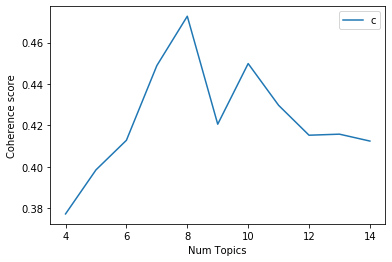

In [33]:
#Para obtener el número óptimo de topics, crearemos una función que sea capaz de determinar la Coherencia obtenida por el 
#cuando se usan diferentes números de topics:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Este modelo evaluará la coherencia en cada caso:
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Añadimos los resultados a la lista vacía "model_list":
        model_list.append(model)
        
        # Calculamos los valores de coherencia y los añadimos a la lista vacía "coherence_values":
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start_ = 4 #Número inicial de topics
end_ = 15 #Número final de topics
step_ = 1 #Incremento en el número de topics con cada nuevo modelo

#Ejecutamos la función para generar nuestos "model_list" y "coherence values":
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

# Representamos los resultados:
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

El número óptimo de topics será aquel que obtenga el resultado más alto de Coherence. En este caso, el número óptimo de topics es **8**.

In [35]:
#El paso final es entrenar el modelo:

#Generamos el modelo LDA:
lda_model = LdaModel(
    corpus=corpus, #Corpus
    id2word=dictionary, #Diccionario id-palabra
    num_topics=8, #Determinamos el número de topics que debe obtener el modelo para el dataset
    passes=20, #Número de pases del modelo sobre el Corpus
    iterations=400, #Número de pases sobre cada registro del Corpus
    alpha='auto',
    eta='auto' #El modelo elegirá automáticamente los mejores parámetros para estos dos parámetros
)

#Obtenemos los 8 topics, con sus 10 palabras más significativas:
lda_model.show_topics(num_words=10, formatted=False)

[(0,
  [('phone', 0.017539898),
   ('case', 0.014074415),
   ('like', 0.010610741),
   ('silicone', 0.008877298),
   ('going', 0.007146224),
   ('sand', 0.007146224),
   ('leather', 0.0071462234),
   ('price', 0.0071462216),
   ('black', 0.007145787),
   ('hold', 0.007145654)]),
 (1,
  [('charge', 0.016673451),
   ('little', 0.013020321),
   ('unit', 0.013018789),
   ('solar', 0.0111912405),
   ('clips', 0.00936562),
   ('real', 0.0075381547),
   ('easy', 0.007537945),
   ('pack', 0.00753734),
   ('charging', 0.007537318),
   ('battery', 0.007537142)]),
 (2,
  [('good', 0.015731156),
   ('great', 0.014316932),
   ('works', 0.01007484),
   ('pair', 0.007246775),
   ('like', 0.007246775),
   ('recommend', 0.007246775),
   ('door', 0.0058329985),
   ('pocket', 0.005832744),
   ('space', 0.005832744),
   ('wallet', 0.005832743)]),
 (3,
  [('great', 0.016676772),
   ('kreg', 0.0073142936),
   ('circular', 0.0073142927),
   ('hand', 0.0073142927),
   ('knife', 0.0073142927),
   ('wear', 0.00

In [36]:
#Determinamos las métricas del modelo:

#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence: ', coherence_lda)


Perplexity:  -7.435464014361795

Coherence:  0.3984795235198465


Una vez obtenidas las métricas para este modelo, probaremos a optimizarlos añadiendo más técnicas de preprocesado:

**B: Eliminación de signos de puntuación y conversión de mayúsculas a minúsculas**

In [36]:
#Cargamos el dataframe desde el csv creado previamente:
dfB = pd.read_csv('Topic_Modeling.csv')
#Creamos una nueva columna donde se eliminan todos los signos de puntuación mediante regex:
dfB["review_text"] = dfB['reviewText'].str.replace('[^\w\s]','')
#Dropeamos la columna reviewText:
dfB2 = dfB.drop(['reviewText'], axis = 1)
#Comprobamos el resultado:
dfB2

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-36-75099367022b>:4: DeprecationWarning: invalid escape sequence \w
  dfB["review_text"] = dfB['reviewText'].str.replace('[^\w\s]','')


,review_text
0,Like some of the other reviews this hat isnt a...
1,fit my caldwell CLA pipod just fine and is the...
2,This stuff is very thin It dries very very qui...
3,I got this bra after a friend recommended it t...
4,I ordered 75 twice and both pairs were huge I ...
...,...
94,This my opinion is a well made 12x24 nylon stu...
95,The best thing about these cords is their leng...
96,Lives up to the reviewsfeels greatlooks greatv...
97,Though expensive this knife is very heavyduty ...


In [37]:
#Convertimos las mayúsculas a minúsculas usando la librería string:
dfB3 = dfB2.apply(lambda x: x.astype(str).str.lower())
#Comprobamos el resultado:
dfB3

,review_text
0,like some of the other reviews this hat isnt a...
1,fit my caldwell cla pipod just fine and is the...
2,this stuff is very thin it dries very very qui...
3,i got this bra after a friend recommended it t...
4,i ordered 75 twice and both pairs were huge i ...
...,...
94,this my opinion is a well made 12x24 nylon stu...
95,the best thing about these cords is their leng...
96,lives up to the reviewsfeels greatlooks greatv...
97,though expensive this knife is very heavyduty ...


In [61]:
#Tokenizamos, y obtenemos los parámetros necesarios para el modelo LDA de la misma manera que en el caso A:

processed_texts = [] 
for text in dfB3['review_text']:
    processed_texts.append(text_preprocessing(text))

dictionary = Dictionary(processed_texts)

corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=8, 
    passes=20, 
    iterations=400, 
    alpha='auto',
    eta='auto' 
)

lda_model.show_topics(num_words=10, formatted=False)

[(0,
  [('bags', 0.009835861),
   ('like', 0.008229723),
   ('going', 0.008229699),
   ('long', 0.0066243703),
   ('stuff', 0.0066241054),
   ('price', 0.0066241054),
   ('screen', 0.006624104),
   ('great', 0.006623377),
   ('youre', 0.0050182254),
   ('washed', 0.0050182254)]),
 (1,
  [('charge', 0.011334846),
   ('little', 0.009940687),
   ('unit', 0.009939742),
   ('great', 0.008545612),
   ('solar', 0.008544753),
   ('knife', 0.005755163),
   ('means', 0.005755147),
   ('thought', 0.0057550445),
   ('good', 0.0057549337),
   ('want', 0.005754886)]),
 (2,
  [('case', 0.020735433),
   ('phone', 0.015604985),
   ('clear', 0.008764385),
   ('button', 0.007054742),
   ('leather', 0.007054233),
   ('ipod', 0.007054233),
   ('received', 0.007054008),
   ('perfectly', 0.0070537534),
   ('color', 0.005344081),
   ('dont', 0.00534408)]),
 (3,
  [('like', 0.013667245),
   ('shoes', 0.010302966),
   ('barrel', 0.006938687),
   ('black', 0.0069386857),
   ('price', 0.0069386857),
   ('locks', 

In [62]:
#Determinamos las métricas del nuevo modelo:

#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence: ', coherence_lda)


Perplexity:  -7.522514094584425

Coherence:  0.4219455507318109


Observamos que los resultados mejoran ligeramente en cuanto a métricas, y aunque esto es bastante subjetivo, da la sensación de que los topics están algo más "definidos" (en el sentido de que las 10 palabras más significativas parecen apuntar todas a un mismo tema de una forma más evidente).

Sin embargo, se observan ahora casos de palabras significativas que no son correctas, como "youre" o "dont", que aparecen en los topics 0 y 2 del modelo B, respectivamente. 

**C: Lemmatización**

Lemmatizar consiste en devolver las palabras a su raíz fundamental, mediante un diccionario de raíces de palabras. En este caso, usaremos el WordNetLemmatizer de NLTK:

In [38]:
# Tokenizamos igual que los casos A y B, eliminando palabras de menos de tres letras y stopwords:
processed_texts = [] 

for text in dfB3['review_text']:
    processed_texts.append(text_preprocessing(text))

# Esta vez, incluimos la tokenización en una columna del dataframe:
dfB3['tokenized_text'] = processed_texts

# Definimos el lematizador:
lem = WordNetLemmatizer()

# Creamos una función que lemmatice textos:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

# Llamamos a la función anterior, e introducimos el resultado en una nueva columna del dataframe: "lemmatized_text"
dfB3['lemmatized_text'] = dfB3["tokenized_text"].apply(lemmatize_text)

# Comprobamos el resultado:
dfB3

,review_text,tokenized_text,lemmatized_text
0,like some of the other reviews this hat isnt a...,"[like, reviews, isnt, baggy, think, didnt, iss...","[like, review, isnt, baggy, think, didnt, issu..."
1,fit my caldwell cla pipod just fine and is the...,"[caldwell, pipod, fine, shortest, picatinny, r...","[caldwell, pipod, fine, shortest, picatinny, r..."
2,this stuff is very thin it dries very very qui...,"[stuff, dries, quick, holding, power, strong, ...","[stuff, dry, quick, holding, power, strong, se..."
3,i got this bra after a friend recommended it t...,"[friend, recommended, cheaper, alternative, br...","[friend, recommended, cheaper, alternative, br..."
4,i ordered 75 twice and both pairs were huge i ...,"[ordered, twice, pairs, huge, wear, shoes, ord...","[ordered, twice, pair, huge, wear, shoe, order..."
...,...,...,...
94,this my opinion is a well made 12x24 nylon stu...,"[opinion, nylon, stuff, locking, drawstring, r...","[opinion, nylon, stuff, locking, drawstring, r..."
95,the best thing about these cords is their leng...,"[best, thing, cords, length, pricemy, little, ...","[best, thing, cord, length, pricemy, little, f..."
96,lives up to the reviewsfeels greatlooks greatv...,"[lives, reviewsfeels, greatlooks, greatvery, c...","[life, reviewsfeels, greatlooks, greatvery, co..."
97,though expensive this knife is very heavyduty ...,"[expensive, knife, heavyduty, firespark, assis...","[expensive, knife, heavyduty, firespark, assis..."


In [39]:
# Transformamos el resultado en lista de strings (igual que el "processed_texts" usado anteriormente):
lemmatized_text = dfB3['lemmatized_text'].tolist()
lemmatized_text

[['like',
  'review',
  'isnt',
  'baggy',
  'think',
  'didnt',
  'issue',
  'size',
  'head',
  'pretty',
  'like',
  'wear',
  'smelled',
  'kinda',
  'funny',
  'wash'],
 ['caldwell',
  'pipod',
  'fine',
  'shortest',
  'picatinny',
  'rail',
  'adapter',
  'market',
  'issue',
  'kinda',
  'issue',
  'us',
  'recessed',
  'allen',
  'head',
  'screw',
  'hold',
  'mean',
  'need',
  'carry',
  'small',
  'allen',
  'wrench',
  'order',
  'retighten',
  'loosens',
  'thumb',
  'screw',
  'oddball',
  'size',
  'screw',
  'mean',
  'local',
  'hardware',
  'store',
  'didnt',
  'thumb',
  'screw',
  'size'],
 ['stuff',
  'dry',
  'quick',
  'holding',
  'power',
  'strong',
  'second',
  'recommend'],
 ['friend',
  'recommended',
  'cheaper',
  'alternative',
  'bra',
  'great',
  'especially',
  'price',
  'cost',
  'paid',
  'brand',
  'held',
  'better',
  'strap',
  'comfortable',
  'dont',
  'band',
  'smoothing',
  'wash',
  'garment',
  'delicate',
  'cycle',
  'woolite',
  

In [41]:
# Una vez tenemos la lista de palabras tokenizadas, entrenamos el modelo de la misma forma que en los casos anteriores:

dictionary = Dictionary(lemmatized_text) # Esta vez, usamos la lista "lemmatized_text"

corpus = [dictionary.doc2bow(doc) for doc in lemmatized_text] # Esta vez, usamos la lista "lemmatized_text"

lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=8, 
    passes=20, 
    iterations=400, 
    alpha='auto',
    eta='auto' 
)

lda_model.show_topics(num_words=10, formatted=False)

[(0,
  [('bulb', 0.025615713),
   ('screen', 0.014163183),
   ('like', 0.009070851),
   ('protector', 0.009070757),
   ('kreg', 0.0077976477),
   ('edge', 0.006524676),
   ('year', 0.0065238085),
   ('light', 0.006523317),
   ('protection', 0.0052514323),
   ('issue', 0.0052505597)]),
 (1,
  [('perfect', 0.009935484),
   ('hard', 0.009935484),
   ('like', 0.0067582317),
   ('firing', 0.0067560775),
   ('cleaning', 0.0067560775),
   ('display', 0.0067560775),
   ('fit', 0.0067560766),
   ('nicely', 0.0067560766),
   ('area', 0.0067560766),
   ('bought', 0.0067560757)]),
 (2,
  [('samsung', 0.008663448),
   ('light', 0.0078102145),
   ('alarm', 0.006953755),
   ('button', 0.0060973694),
   ('headset', 0.0060966946),
   ('bag', 0.005242028),
   ('volume', 0.005241152),
   ('noise', 0.0052409866),
   ('screw', 0.0043992223),
   ('product', 0.004386164)]),
 (3,
  [('charge', 0.014597386),
   ('unit', 0.014597335),
   ('solar', 0.01100491),
   ('good', 0.009208599),
   ('leather', 0.00741234

In [42]:
#Determinamos las métricas del nuevo modelo:

#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence: ', coherence_lda)


Perplexity:  -7.436209802677934

Coherence:  0.41181142137516447


Los resultados en los tres casos son muy parejos, y ordenados de menor a mayor Perplexity:

Modelo B < Modelo C = Modelo A

Teniendo en cuenta los resultados, parece que el mejor preprocesado es el del modelo B, esto es:

- Tokenizar
- Eliminar palabras de menos de 3 letras
- Eliminar stopwords
- Eliminación de signos de puntuación
- Conversión de mayúsculas a minúsculas

Con el preprocesado y los parámetros del modelo ya definidos, haremos un nuevo entrenamiento, esta vez usando todas las reviews de las cuatro categorías a nuestro alcance:

In [43]:
#Unimos los cuatro subsets en un solo data frame:
df1 = reviews_tools.combine_first(reviews_phones)
df2 = df1.combine_first(reviews_clothing)
df3 = df2.combine_first(reviews_sports)

#Hacemos un shuffle de todos los resultados, de modo que estén mezclados y no por orden de entrada en el dataset conjunto:
df_full = df3.sample(frac=1)

#Confirmamos el resultado:
df_full.shape

(296337, 9)

In [45]:
#Creamos una nueva columna donde se eliminan todos los signos de puntuación mediante regex:
df_full["review_text"] = df_full['reviewText'].str.replace('[^\w\s]','')
#Nos quedamos únicamente con esta nueva columna:
df_full2 = dfB.drop(['reviewText'], axis = 1)
#Comprobamos el resultado:
df_full2.head()

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-45-5a33affa4504>:2: DeprecationWarning: invalid escape sequence \w
  df_full["review_text"] = df_full['reviewText'].str.replace('[^\w\s]','')


,review_text
0,Like some of the other reviews this hat isnt a...
1,fit my caldwell CLA pipod just fine and is the...
2,This stuff is very thin It dries very very qui...
3,I got this bra after a friend recommended it t...
4,I ordered 75 twice and both pairs were huge I ...


In [46]:
#Convertimos las mayúsculas a minúsculas usando la librería string:
df_full3 = df_full2.apply(lambda x: x.astype(str).str.lower())
#Comprobamos el resultado:
df_full3.head()

,review_text
0,like some of the other reviews this hat isnt a...
1,fit my caldwell cla pipod just fine and is the...
2,this stuff is very thin it dries very very qui...
3,i got this bra after a friend recommended it t...
4,i ordered 75 twice and both pairs were huge i ...


In [50]:
#Eliminamos los nulos para quedarnos con el dataframe definitivo:
df_full3.dropna(inplace=True)
df_final = df_full3
df_final.head()

,review_text
0,like some of the other reviews this hat isnt a...
1,fit my caldwell cla pipod just fine and is the...
2,this stuff is very thin it dries very very qui...
3,i got this bra after a friend recommended it t...
4,i ordered 75 twice and both pairs were huge i ...


In [54]:
#Guardamos el resultado en un csv para poder reutilizarlo en caso de tener que cerrar el notebook:
df_final.to_csv(r'Topic_Modeling_Full.csv', index = False)

In [51]:
#Tokenizamos, y obtenemos los parámetros necesarios para el modelo LDA de la misma manera que en el caso B:

processed_texts = [] 
for text in df_final['review_text']:
    processed_texts.append(text_preprocessing(text))

dictionary = Dictionary(processed_texts)

corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=8, 
    passes=20, 
    iterations=400, 
    alpha='auto',
    eta='auto' 
)

lda_model.show_topics(num_words=10, formatted=False)

[(0,
  [('great', 0.013143604),
   ('like', 0.011572331),
   ('door', 0.006699713),
   ('barrel', 0.006699712),
   ('screws', 0.005075503),
   ('fine', 0.005075503),
   ('order', 0.005075503),
   ('time', 0.005075503),
   ('pages', 0.005075503),
   ('better', 0.0050755027)]),
 (1,
  [('case', 0.0235898),
   ('screen', 0.014789314),
   ('charge', 0.008922428),
   ('phone', 0.007944612),
   ('protector', 0.0069667986),
   ('unit', 0.006966798),
   ('button', 0.0059893327),
   ('like', 0.0059890747),
   ('solar', 0.005988983),
   ('clear', 0.0050112964)]),
 (2,
  [('great', 0.010653367),
   ('alarm', 0.009340378),
   ('headphones', 0.008030729),
   ('music', 0.008030729),
   ('player', 0.0067195664),
   ('long', 0.0067195664),
   ('best', 0.0067195664),
   ('plate', 0.0067188637),
   ('like', 0.0054086186),
   ('hardware', 0.0054079248)]),
 (3,
  [('bulbs', 0.028105812),
   ('color', 0.007189759),
   ('like', 0.007189758),
   ('bulb', 0.007189758),
   ('good', 0.007189757),
   ('lights', 

In [52]:
#Determinamos las métricas del nuevo modelo:

#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence: ', coherence_lda)


Perplexity:  -7.518237201256651

Coherence:  0.3971676509074095


Las métricas del modelo se han resentido ligeramente. Esto es lógico si tenemos en cuenta que ahora tenemos muchas más rewiews (y con ello muchas más palabras), y que el dataset completo está desbalanceado (no tenemos la misma cantidad de reviews para las cuatro categorías, como sí ocurría con la versión reducida).

Para evaluar la distribución de topics manualmente, podemos utilizar pyLADvis para representar los resultados del modelo:

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'topic_modeling.html') #Guardamos los resultados en un archivo html para su posterior visualización:
#Representamos los resultados en el propio notebook también:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.154978 -0.111503       1        1  22.322781
2      0.015293  0.011722       2        1  15.011380
4     -0.030738  0.085039       3        1  13.762047
6      0.133091 -0.119357       4        1  13.291381
0     -0.005811  0.077620       5        1  10.858289
3      0.048597  0.031208       6        1   9.701065
5      0.006556  0.014940       7        1   9.355832
7     -0.012010  0.010330       8        1   5.697226, topic_info=           Term       Freq      Total Category  logprob  loglift
1202      bulbs  10.000000  10.000000  Default  30.0000  30.0000
686      screen  12.000000  12.000000  Default  29.0000  29.0000
235     samsung   8.000000   8.000000  Default  28.0000  28.0000
150        case  27.000000  27.000000  Default  27.0000  27.0000
82        shoes   5.000000   5.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
398       phone   1.463906  16.108986   Topic8  -4.9284   0.4669
46    recommend   0.995445   9.173449   Topic8  -5.3141   0.6443
356        good   0.995445  13.288633   Topic8  -5.3141   0.2737
64        great   0.995445  22.323772   Topic8  -5.3141  -0.2450
150        case   0.995445  27.485594   Topic8  -5.3141  -0.4530

[495 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
130       1  0.183046   able
130       2  0.366091   able
130       3  0.183046   able
130       4  0.183046   able
130       6  0.183046   able
...     ...       ...    ...
1280      6  0.259225  years
1280      8  0.259225  years
385       3  0.506101  youre
385       4  0.253051  youre
385       6  0.253051  youre

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 7, 1, 4, 6, 8])

Podemos observar la existencia de cuatro clústeres, dos de ellos muy próximos entre sí, a saber:

- Cluster A: topic 1
- Cluster B: topic 4
- Cluster C: topics 3 y 5
- Cluster D: topics 8, 2, 7 y 6

La gran mayoría de las palabras que destaca el topic 1 tienen que ver con el tema **Cell Phones and Accessories** (case, screen, charge, phone, protector...)

El topic 4 tiene palabras que pueden relacionarse también con el mundo de la telefonía (como Samsung o headset), pero la empresa Samsung tiene más negocios aparte de los móviles, y los headsets se pueden usar también como protección frente al ruido de maquinaria, por ejemplo. Es un topic claramente más difuso que el 1, pero hay palabras como noise, candle y pocket son exclusivas del topic 4. Candle tiene más sentido en **Tools and Home Improvement**, pero noise y pocket son más ambiguas, pues también pegan con **Sports** y **Clothing**, respectivamente.

En los topics 3 y 5 (cluster C), también hay palabras exclusivas como bags y barrel. Bags tiene sentido encuadrada tanto en el tema de **clothing** como en **Sports**, y barrel es un tipo de bolsa de deportes, que tiene sentido en los mismos temas. En realidad, **Clothing, Shoes and Jewelry** y **Sports and Outdoors** son dos temas que deberían estar relacionados (ropa de deportes puede ser un punto en común), y tendría sentido que estuvieran representados en clusteres muy cercanos o incluso en el mismo cluster. 

El cluster D es bastante más heterogéneo. En los cuatro topics destacan palabras como shoes, work, headphones, bulbs o bench, que podrían relacionarse con temas distintos cada una.

En general, parece claro que hay temas relacionados con teléfonos, ropa y, en menor medida, herramientas. Claramente, el tema más difícil de encuadrar es deportes, pues no aparecen muchas palabras relacionadas en ningún topic, y en los casos donde hay, predominan también palabras relacionadas con otros temas o simplemente palabras ambiguas (como like o great). 

En definitiva, aunque el modelo parece bien encaminado, aún tiene limitaciones a la hora de discernir topics que a priori no son tan similares entre sí.